In [1]:
# loading some libraries 

import pandas as pd
import numpy as np 
import random
from random import shuffle
from numpy import newaxis
import itertools
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RepeatVector, TimeDistributed, Input
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
# mapping dictionary

aminoacidos=pd.read_html('https://es.wikipedia.org/wiki/Nomenclatura_de_amino%C3%A1cidos', header=0)[0]

mapping = pd.get_dummies(aminoacidos['Código de una letra'])
mapping = pd.Series(list(mapping.values),index=mapping.columns).to_dict()

In [3]:
# lets create a dataset of sequences randomly, and a test of contact also randomly
# for each sequence of lenght N there will an input of dim 1, and N outputs of dimension 4

sequence = list('TSSKFNECQLNNLNALEPDHRVESEGGLIETWNSQHPELQCAGVTVSKRTLNRNGLHLPSYSPYPQMIIVVQGKGAIGFAFPGCPETFEKPQQQSSRRGSRSQQQLQDSHQKIRHFNEGDVLVIPPGVPYWTYNTGDEPVVAISLLDTSNFNNQLDQNPRVFYLAGNPDIEHPETMQQQQQQKSHGGRKQGQHQQQEEEGGSVLSGFSKHFLAQSFNTNEDTAEKLRSPDDERKQIVTVEGGLSVISPKWQEQEDEDEDEDEEYEQTPSYPPRRPSHGKHEDDEDEDEEEDQPRPDHPPQRPSRPEQQEPRGRGCQTRNGVEENICTMKLHENIARPSRADFYNPKAGRISTLNSLTLPALRQFGLSAQYVVLYRNGIYSPHWNLNANSVIYVTRGKGRVRVVNCQGNAVFDGELRRGQLLVVPQNFVVAEQGGEQGLEYVVFKTHHNAVSSYIKDVFRAIPSEVLSNSYNLGQSQVRQLKYQGNSGPLVNP')

contact_1 = sequence[:] # Copy words
random.shuffle(contact_1) # Shuffle newwords

contact_2 = sequence[:] 
random.shuffle(contact_2) 

contact_3 = sequence[:] 
random.shuffle(contact_3)

contact_4 = sequence[:] 
random.shuffle(contact_4)

In [4]:
data = pd.DataFrame({'sequence': sequence, 
                    'contact1': contact_1,
                    'contact2': contact_2,
                    'contact3': contact_3,
                    'contact4': contact_4})

# I need 2 columns, one for the aminoacid of the sequence and the other for the contacts
data['contact'] = data['contact1'].map(str) + data['contact2'].map(str) + data['contact3'].map(str) + data['contact4'].map(str)
data = data[['sequence','contact']]

data

,sequence,contact
0,T,VGEK
1,S,QGQN
2,S,NKGQ
3,K,DHQP
4,F,YVSQ
...,...,...
487,P,PTVN
488,L,WENN
489,V,NLEP
490,N,EQWH


# One-to-many (1-4)

## Processing data for model 

In [5]:
# I need to manipulate this dataframe to convert to one-hot encoding 
data['convertions'] = data['contact'].map(list) 

In [4]:
# funciton to transform to one-hot 
def one_hot_transform(secuencia):
    
    keys, inv = np.unique(secuencia, return_inverse=True)
    vals = np.array([mapping[key] for key in keys])
    sequence_hot = vals[inv]
    
    return sequence_hot

In [7]:
data['hot_sequence'] = data['sequence'].map(one_hot_transform)

In [8]:
# Now lets transform the 'convertions' column to one-hot
hot_contact = []
for i in range(len(data)): 
    hot_contact.append(one_hot_transform(data['convertions'][:][i]))

data['hot_convertion'] = hot_contact

## Model 

In [9]:
X = one_hot_transform(sequence) # we have to reshape this values 
X = X[:,newaxis,:]
Y = np.asarray(hot_contact, dtype=np.float32)

In [10]:
print(X.shape)
print(Y.shape)

(492, 1, 20)
(492, 4, 20)


### Version 1

In [11]:
# LSTM, there's a BiLSTM too  
# ver este link: 
# https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras
# y este: 
# https://stackoverflow.com/questions/52138290/how-can-we-define-one-to-one-one-to-many-many-to-one-and-many-to-many-lstm-ne

hidden_nodes_l1 = 10
hidden_nodes_l2 = 5

model = Sequential()
# batch = None, timesteps = 1, features = 20
model.add(LSTM(hidden_nodes_l1, batch_input_shape=(None, 1, 20)))  
model.add(RepeatVector(4))
model.add(LSTM(hidden_nodes_l2, return_sequences=True)) 
#model.add(Bidirectional(LSTM(hidden_nodes_l2, return_sequences=True))) 
model.add(TimeDistributed(Dense(20, activation='softmax')))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

In [12]:
print(model.input_shape)
print(model.output_shape)
model.summary()

(None, 1, 20)
(None, 4, 20)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                1240      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 5)              320       
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 20)             120       
Total params: 1,680
Trainable params: 1,680
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Optimizing the network weights
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

history = model.fit(x=X_train, 
                    y=Y_train, 
                    batch_size=10, 
                    epochs=100)

Epoch 1/100
40/40 [==============================] - 3s 5ms/step - loss: 2.9915 - accuracy: 0.0978
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 2.9760 - accuracy: 0.0961
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 2.9585 - accuracy: 0.1018
Epoch 4/100
40/40 [==============================] - 0s 5ms/step - loss: 2.9400 - accuracy: 0.0929
Epoch 5/100
40/40 [==============================] - 0s 5ms/step - loss: 2.9122 - accuracy: 0.1046
Epoch 6/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8832 - accuracy: 0.1046
Epoch 7/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8839 - accuracy: 0.1099
Epoch 8/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8730 - accuracy: 0.0911
Epoch 9/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8655 - accuracy: 0.0963
Epoch 10/100
40/40 [==============================] - 0s 6ms/step - loss: 2.8651 - accuracy: 0.0951
Epoch 11/

40/40 [==============================] - 0s 5ms/step - loss: 2.8005 - accuracy: 0.1150
Epoch 84/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8265 - accuracy: 0.0968
Epoch 85/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8174 - accuracy: 0.1138
Epoch 86/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8155 - accuracy: 0.1047
Epoch 87/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8280 - accuracy: 0.0887
Epoch 88/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8186 - accuracy: 0.1000
Epoch 89/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8151 - accuracy: 0.1032
Epoch 90/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8107 - accuracy: 0.1130
Epoch 91/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8108 - accuracy: 0.1018
Epoch 92/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8065 - accuracy: 0.0950
Epoch 93/100


In [14]:
# model.save_weights('./elmo-model.h5')
# I need to compare this predictions with real values (Y_test)
predicts = model.predict(X_test) 

In [20]:
# convertion to one_hot format 
one_hot_predicts = [] 

for i in range(len(predicts)):
    for j in range(len(predicts[0])): 
        
        one_hot_predicts.append(np.asarray(tf.one_hot(tf.argmax(predicts[i][j]), depth = 20)).reshape(1,20))

one_hot_predicts = [one_hot_predicts[i:i + 4] for i in range(0, len(one_hot_predicts), 4)]

In [ ]:
# and if you want to retrieve the exact format: 
print(np.squeeze(np.asarray(one_hot_predicts), axis=(2,)).shape)
print(type(np.squeeze(np.asarray(one_hot_predicts), axis=(2,))))
np.squeeze(np.asarray(one_hot_predicts), axis=(2,))

In [15]:
# evaluate the model
train_acc = model.evaluate(X_train, Y_train, verbose=0)#batch_size=BATCH_SIZE,
print(' Train accuracy:', train_acc[1])
test_acc = model.evaluate(X_test, Y_test, verbose=0)
print(' Test accuracy:', test_acc[1])

 Train accuracy: 0.11005088686943054
 Test accuracy: 0.09848485141992569


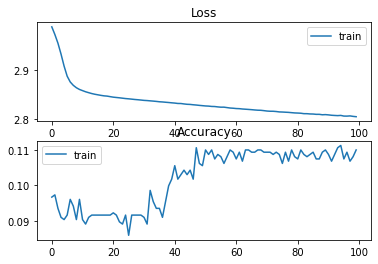

In [16]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
#pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

### Version 2

In [57]:
# LSTM, version_2 
# this version needs to repeat by 4 each sequence's aminoacid
hidden_nodes_l1 = 10
hidden_nodes_l2 = 5

model = Sequential()

model.add(Input(shape=(4,20)))
model.add(LSTM(hidden_nodes_l2, return_sequences=True)) 
#model.add(Bidirectional(LSTM(hidden_nodes_l2, return_sequences=True))) 
model.add(Dense(20, activation='softmax'))
#model.add(TimeDistributed(Dense(20, activation='softmax')))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

In [58]:
print(model.input_shape)
print(model.output_shape)
model.summary()

(None, 4, 20)
(None, 4, 20)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 4, 5)              520       
_________________________________________________________________
dense_6 (Dense)              (None, 4, 20)             120       
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________


In [59]:
repeated_sequence = []

for i in range(len(X)):
    
    repeated_sequence.append(tf.keras.layers.RepeatVector(n=4)(X[i]))

In [60]:
X_v2 = np.squeeze(np.asarray(repeated_sequence), axis=(1,))

In [61]:
# Optimizing the network weights
X_train, X_test, Y_train, Y_test = train_test_split(X_v2, Y, test_size=0.2, random_state=0)

history = model.fit(x=X_train, 
                    y=Y_train, 
                    batch_size=10, 
                    epochs=100)

Epoch 1/100
40/40 [==============================] - 4s 5ms/step - loss: 3.0016 - accuracy: 0.0549
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 2.9826 - accuracy: 0.0784
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 2.9747 - accuracy: 0.0826
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 2.9587 - accuracy: 0.0736
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 2.9464 - accuracy: 0.0974
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 2.9392 - accuracy: 0.0896
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 2.9269 - accuracy: 0.1017
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 2.9194 - accuracy: 0.1078
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 2.9076 - accuracy: 0.0964
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 2.9038 - accuracy: 0.0945
Epoch 11/

40/40 [==============================] - 0s 4ms/step - loss: 2.7719 - accuracy: 0.1223
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 2.8000 - accuracy: 0.1139
Epoch 85/100
40/40 [==============================] - 0s 4ms/step - loss: 2.7710 - accuracy: 0.1196
Epoch 86/100
40/40 [==============================] - 0s 4ms/step - loss: 2.7720 - accuracy: 0.1077
Epoch 87/100
40/40 [==============================] - 0s 4ms/step - loss: 2.7797 - accuracy: 0.1101
Epoch 88/100
40/40 [==============================] - 0s 4ms/step - loss: 2.7844 - accuracy: 0.1313
Epoch 89/100
40/40 [==============================] - 0s 4ms/step - loss: 2.7823 - accuracy: 0.1231
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 2.7881 - accuracy: 0.1135
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 2.7803 - accuracy: 0.0971
Epoch 92/100
40/40 [==============================] - 0s 4ms/step - loss: 2.7743 - accuracy: 0.1059
Epoch 93/100


In [62]:
# evaluate the model
train_acc = model.evaluate(X_train, Y_train, verbose=0)#batch_size=BATCH_SIZE,
print(' Train accuracy:', train_acc[1])
test_acc = model.evaluate(X_test, Y_test, verbose=0)
print(' Test accuracy:', test_acc[1])

 Train accuracy: 0.10877862572669983
 Test accuracy: 0.047979798167943954


## Retrieving letter representation (not important by now) 

In [17]:
anti_sequence = []
for i in range(len(data)):
        anti_sequence.append([ k for k,v in mapping.items() if (v - X[i][0]).any() == 0 ])

In [18]:
# initial data
anti_contact = []
for i in range(len(data)):
    for j in range(len(Y[0])): 
        anti_contact.append([ k for k,v in mapping.items() if (v - Y[i][j]).any() == 0 ])
        
anti_contact = [anti_contact[i:i + 4] for i in range(0, len(anti_contact), 4)]

In [21]:
# predicted data 
anti_predict = []
for i in range(len(predicts)):
    for j in range(len(predicts[0])): 
        anti_predict.append([ k for k,v in mapping.items() if (v - one_hot_predicts[i][j]).any() == 0 ])
        
anti_predict = [anti_predict[i:i + 4] for i in range(0, len(anti_predict), 4)]

In [22]:
# processing data correctly 
anti_predict_well = []
for i in range(len(anti_predict)): 
    anti_predict_well.append(list(itertools.chain.from_iterable(anti_predict[i])))

# Many-to-many (3-2)

## Processing data for model 

In [5]:
# for this model we need to reload the dataframe from 4th box, but only 
# considering 2 contacts because the 'sequence' contacts are as 'input'

data = pd.DataFrame({'sequence': sequence, 
                    'contact1': contact_1,
                    'contact2': contact_2,
                    'contact3': contact_3,
                    'contact4': contact_4})

# I need 2 columns, one for the aminoacid of the sequence and the other for the contacts
data['contact'] = data['contact1'].map(str) + data['contact2'].map(str) 
data = data[['sequence','contact']]

data

,sequence,contact
0,T,HL
1,S,EY
2,S,EK
3,K,LQ
4,F,PS
...,...,...
487,P,IT
488,L,IP
489,V,HS
490,N,PT


In [7]:
new_column = []
for i in range(len(data)):
    if i == 0:
        new_column.append(data.loc[i][0] + data.loc[i+1][0])
    elif i == (len(data)-1):
        new_column.append(data.loc[i-1][0] + data.loc[i][0])
    else:
        new_column.append(data.loc[i-1][0] + data.loc[i][0] + data.loc[i+1][0])

In [8]:
data['sequence_neighbors'] = new_column
data = data[['sequence_neighbors','contact']]
data

,sequence_neighbors,contact
0,TS,HL
1,TSS,EY
2,SSK,EK
3,SKF,LQ
4,KFN,PS
...,...,...
487,GPL,IT
488,PLV,IP
489,LVN,HS
490,VNP,PT


In [9]:
# I need to manipulate this dataframe to convert to one-hot encoding 
data['seq_convertions'] = data['sequence_neighbors'].map(list)
data['contact_convertions'] = data['contact'].map(list)

In [10]:
# again lets transform the 'convertions' columns to one-hot
hot_seq = []
for i in range(len(data)): 
    hot_seq.append(one_hot_transform(data['seq_convertions'][:][i]))

In [11]:
hot_contact = []
for i in range(len(data)): 
    hot_contact.append(one_hot_transform(data['contact_convertions'][:][i]))

## Model 

There will be a problem because the first and last rows have two aminoacids, we can add an 'empty' aminoacid representing the beginning and the end of the sequence. It could be a vector of zeros and lenght 20.   

In [12]:
hot_seq[0] = np.vstack((np.zeros((1,20)), hot_seq[0]))
hot_seq[len(data)-1] = np.vstack((hot_seq[len(data)-1], np.zeros((1,20))))

In [13]:
X = np.asarray(hot_seq, dtype=np.float32)
Y = np.asarray(hot_contact, dtype=np.float32)

In [14]:
print(X.shape)
print(Y.shape)

(492, 3, 20)
(492, 2, 20)


In [15]:
# LSTM 

hidden_nodes_l1 = 10
hidden_nodes_l2 = 5

model = Sequential()
model.add(LSTM(hidden_nodes_l1, batch_input_shape=(None, 3, 20)))#, stateful=True))
model.add(RepeatVector(2))
model.add(LSTM(hidden_nodes_l2, return_sequences=True)) 
#model.add(Bidirectional(LSTM(hidden_nodes_l2, return_sequences=True))) 
model.add(TimeDistributed(Dense(20, activation='softmax')))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

In [16]:
print(model.input_shape)
print(model.output_shape)
model.summary()

(None, 3, 20)
(None, 2, 20)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                1240      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 5)              320       
_________________________________________________________________
time_distributed (TimeDistri (None, 2, 20)             120       
Total params: 1,680
Trainable params: 1,680
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Optimizing the network weights
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

history = model.fit(X_train, Y_train, 
                    batch_size=1, 
                    epochs=10, 
                    verbose=1,
                    validation_data=(X_test, Y_test))

Epoch 1/10
393/393 [==============================] - 7s 7ms/step - loss: 2.9810 - accuracy: 0.0926 - val_loss: 2.9466 - val_accuracy: 0.0505
Epoch 2/10
393/393 [==============================] - 2s 4ms/step - loss: 2.9062 - accuracy: 0.0607 - val_loss: 2.8975 - val_accuracy: 0.0707
Epoch 3/10
393/393 [==============================] - 2s 4ms/step - loss: 2.8507 - accuracy: 0.0920 - val_loss: 2.8845 - val_accuracy: 0.0707
Epoch 4/10
393/393 [==============================] - 2s 4ms/step - loss: 2.8638 - accuracy: 0.0726 - val_loss: 2.8802 - val_accuracy: 0.0707
Epoch 5/10
393/393 [==============================] - 2s 4ms/step - loss: 2.8611 - accuracy: 0.0756 - val_loss: 2.8793 - val_accuracy: 0.0707
Epoch 6/10
393/393 [==============================] - 2s 4ms/step - loss: 2.8273 - accuracy: 0.1046 - val_loss: 2.8800 - val_accuracy: 0.0758
Epoch 7/10
393/393 [==============================] - 2s 4ms/step - loss: 2.8176 - accuracy: 0.1015 - val_loss: 2.8802 - val_accuracy: 0.0909
Epoch 

In [18]:
predicts = model.predict(X_test) 

In [22]:
predicts.shape

(99, 2, 20)

In [40]:
# convertion to one_hot format 
one_hot_predicts = [] 

for i in range(len(predicts)):
    for j in range(len(predicts[0])): 
        
        one_hot_predicts.append(np.asarray(tf.one_hot(tf.argmax(predicts[i][j]), depth = 20)).reshape(1,20))

one_hot_predicts = [one_hot_predicts[i:i + 2] for i in range(0, len(one_hot_predicts), 2)]

In [46]:
# and if you want to retrieve the exact format: 
print(np.squeeze(np.asarray(one_hot_predicts), axis=(2,)).shape)
print(type(np.squeeze(np.asarray(one_hot_predicts), axis=(2,))))
np.squeeze(np.asarray(one_hot_predicts), axis=(2,))

In [44]:
# evaluate the model (LSTM)
train_acc = model.evaluate(X_train, Y_train, verbose=0)#batch_size=BATCH_SIZE,
print(' Train accuracy:', train_acc[1])
test_acc = model.evaluate(X_test, Y_test, verbose=0)
print(' Test accuracy:', test_acc[1])

 Train accuracy: 0.1450381726026535
 Test accuracy: 0.11616161465644836


In [97]:
# evaluate the model (BiLSTM)
train_acc = model.evaluate(X_train, Y_train, verbose=0)#batch_size=BATCH_SIZE,
print(' Train accuracy:', train_acc[1])
test_acc = model.evaluate(X_test, Y_test, verbose=0)
print(' Test accuracy:', test_acc[1])

 Train accuracy: 0.20610687136650085
 Test accuracy: 0.06060606241226196
